In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time as time
import numpy as np
import h5py
from scipy.stats import pearsonr
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.plots import display_candidate_loss
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.torch_fwrf import get_value

In [3]:
import torch
import torch.nn as nn

print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [4]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = root_dir+"output/S%02d/%s_%s/" % (subject,model_name,timestamp) 
video_dir  = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: May-24-2020_1943


# Load stimuli

In [5]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [6]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
image_data = 0.2126*image_data[:,0:1]+ 0.7152*image_data[:,1:2]+ 0.0722*image_data[:,2:3]
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(10000, 1, 227, 227)
float32
0.0 1.0


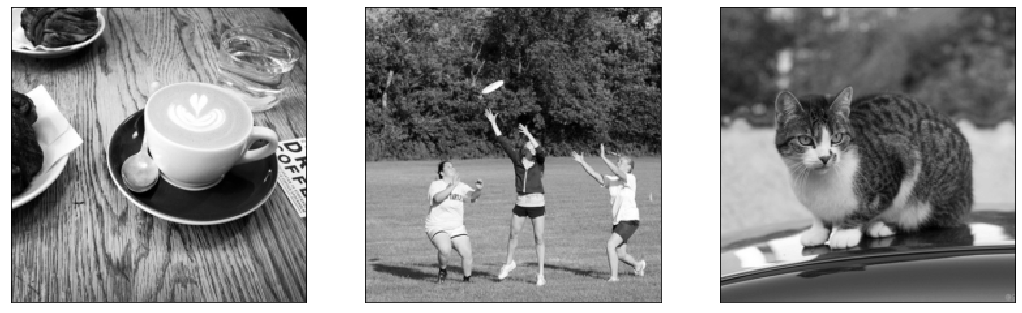

In [7]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i,0], cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [8]:
from src.file_utility import load_mask_from_nii, view_data

In [9]:
def inflate1d(x):
    y = x.astype(np.float32)
    return 1.*y + 0.5*np.roll(y,-1,axis=0) + 0.5*np.roll(y,1,axis=0)

def inflate2d(x):
    y = inflate1d(x)
    return 1.*y + 0.5*np.roll(y,-1,axis=1) + 0.5*np.roll(y,1,axis=1)

def inflate3d(x):
    y = inflate2d(x)
    return 1.*y + 0.5*np.roll(y,-1,axis=2) + 0.5*np.roll(y,1,axis=2)

In [11]:
voxel_r2_full      = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%(subject))
tight_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%subject)
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
voxel_roi_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))

brain_nii_shape = brain_mask_full.shape
print (brain_nii_shape)

###
#general_mask_full = voxel_roi_full.flatten()>0
general_mask_full = (inflate3d(voxel_roi_full>=0)>=1.).flatten()

(81, 104, 83)


In [12]:
brain_mask_full = tight_mask_full.flatten().astype(bool)
voxel_r2_brain  = voxel_r2_full.flatten()[brain_mask_full]
voxel_idx_brain = np.arange(len(brain_mask_full))[brain_mask_full]
voxel_roi_brain = voxel_roi_full.flatten()[brain_mask_full]
print ('brain_mask nv = ', np.sum(brain_mask_full))

general_mask_full = general_mask_full.flatten().astype(bool)
voxel_r2_general  = voxel_r2_full.flatten()[general_mask_full]
voxel_idx_general = np.arange(len(general_mask_full))[general_mask_full]
voxel_roi_general = voxel_roi_full.flatten()[general_mask_full]
print ('general mask nv = ', np.sum(general_mask_full))

brain_mask nv =  238508
general mask nv =  171795


## Display a slice of the data

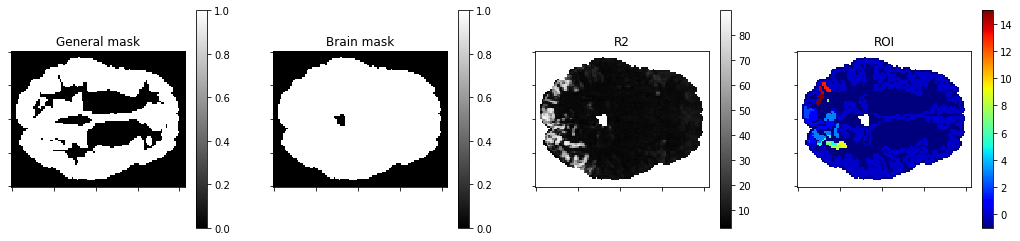

In [13]:
volume_r2         = view_data(voxel_r2_full.shape, voxel_idx_brain, np.nan_to_num(voxel_r2_brain))
volume_general_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), general_mask_full)
volume_brain_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), brain_mask_full)
volume_brain_roi  = view_data(voxel_r2_full.shape, voxel_idx_brain, voxel_roi_brain)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,4,1)
plt.imshow(volume_general_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('General mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,2)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Brain mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,3)
plt.imshow(volume_r2[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('R2')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,4)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

## Select what mask to use

In [14]:
voxel_mask = brain_mask_full
voxel_idx = voxel_idx_brain
voxel_roi = voxel_roi_brain
voxel_r2  = voxel_r2_brain

In [15]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=-1)
print (voxel_data.shape)

/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.113, <sigma> = 0.225
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.090, <sigma> = 0.200
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.117, <sigma> = 0.216
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.089, <sigma> = 0.190
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.098, <sigma> = 0.214
/home/styvesg/repo.data/datasets/ns

## Voxel grouping and voxel ROI iterator

In [16]:
from src.roi import iterate_roi, roi_map

roi_group_names = ['V1', 'V2', 'V3', 'V4', 'VO', 'PHC', 'MST', 'hMT', 'LO', 'V3a/b', 'IPS', 'All']
roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23], np.arange(0,24)]
for roi_mask, roi_name in iterate_roi(roi_group, voxel_roi, roi_map, group_name=roi_group_names):
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

2261 	: V1
1681 	: V2
1442 	: V3
462 	: V4
525 	: VO
374 	: PHC
54 	: MST
281 	: hMT
517 	: LO
990 	: V3a/b
2148 	: IPS
106847 	: All


## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [17]:
data_size, nv = voxel_data.shape 
print ("Total number of voxels = %d" % nv)

ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print ("Validation size =", val_size, ", Training size =", trn_size)

Total number of voxels = 238508
Validation size = 3000 , Training size = 27000


In [18]:
## double and triple check that I haven't misaligned the image and responses.
trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]

stim_data = image_data[ordering_data]  # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_image_data = image_data[:1000]
#val_stim_data = stim_data[shared_mask]

In [19]:
del stim_data
del voxel_data

# Create model
By arbitrary convention, all variables, ojects or functions that return either of those on the device will begin with an underscore.

In [20]:
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

In [21]:
class add_nonlinearity(nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

In [22]:
_gaborizer = Gaborizer(num_orientations=4, cycles_per_stim=logspace(12)(6., 92.),
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

torch.Size([4, 1, 12, 12])
torch.Size([4, 1, 12, 12])


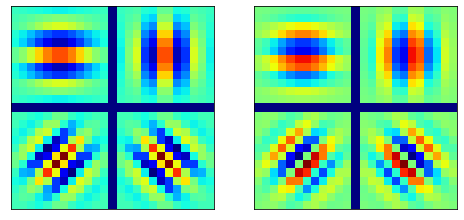

In [23]:
for _p in _fmaps_fn.parameters():
    print (_p.size())
##
plt.figure(figsize=(8, 4))
for k,_p in enumerate(_fmaps_fn.parameters()):
    plt.subplot(1,2,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_p)[:,0], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [24]:
_x = torch.tensor(image_data[:100]).to(device) # the input variable.
_fmaps = _gaborizer(_x)

for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 4, 26, 26])
torch.Size([100, 4, 33, 33])
torch.Size([100, 4, 42, 42])
torch.Size([100, 4, 53, 53])
torch.Size([100, 4, 68, 68])
torch.Size([100, 4, 87, 87])
torch.Size([100, 4, 111, 111])
torch.Size([100, 4, 142, 142])
torch.Size([100, 4, 181, 181])
torch.Size([100, 4, 232, 232])
torch.Size([100, 4, 297, 297])
torch.Size([100, 4, 381, 381])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


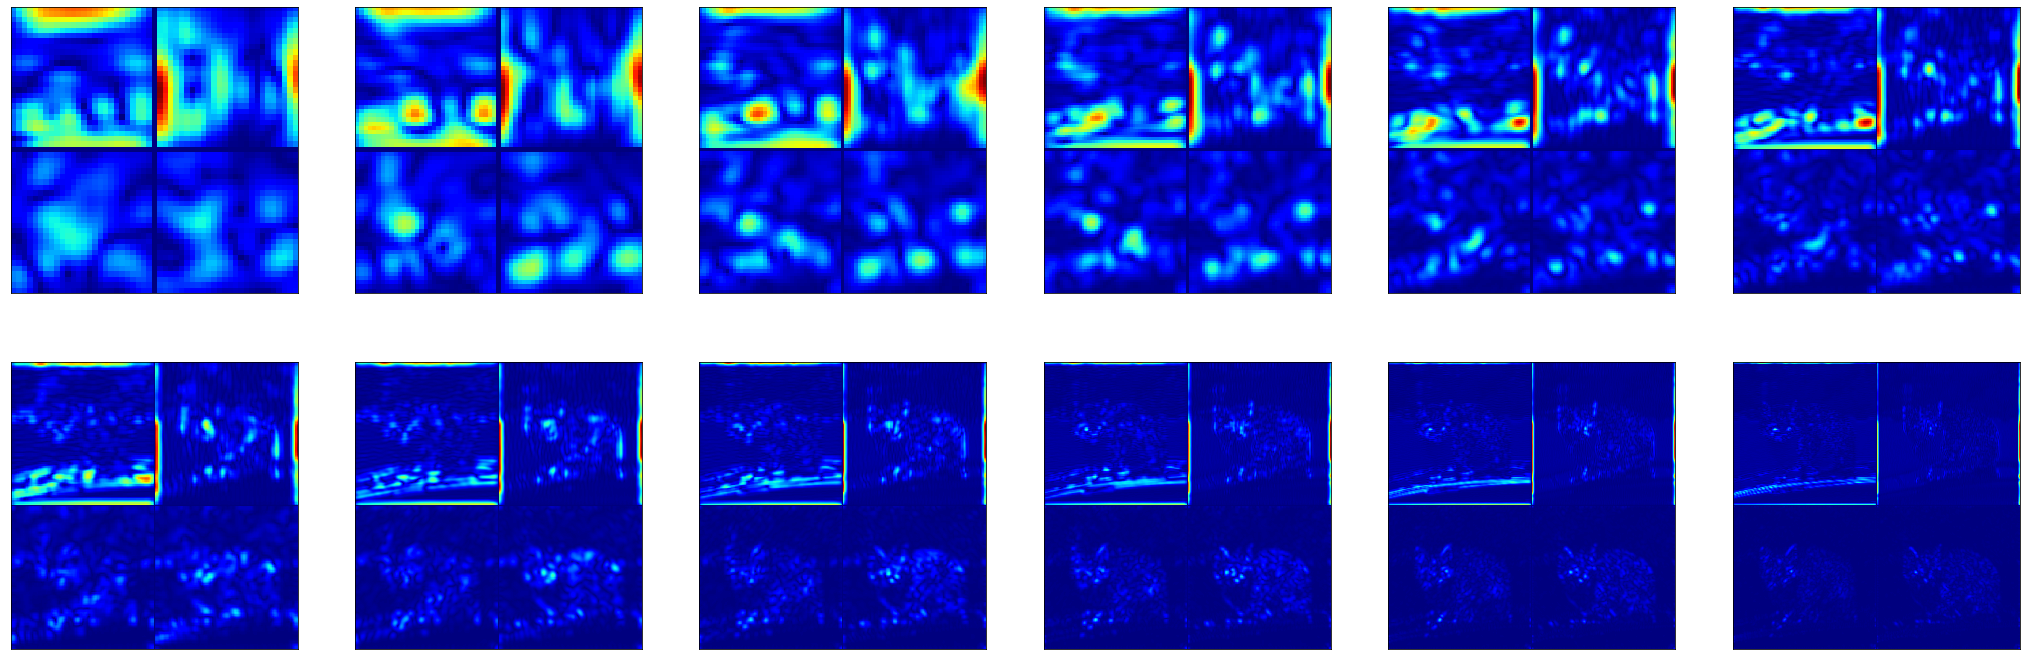

In [25]:
plt.figure(figsize=(36,12))
for k,_fm in enumerate(_fmaps[:12]):
    plt.subplot(2,6,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[8], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [26]:
from src.torch_feature_space import filter_dnn_feature_maps
# I used image_data because the repeats are not relevant
_fmaps_fn, lmask, fmask, tuning_masks = filter_dnn_feature_maps(image_data, _fmaps_fn, batch_size=100, fmap_max=512)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100it [00:50,  1.97it/s]

layer: 0, shape=(100, 4, 26, 26)
layer: 1, shape=(100, 4, 33, 33)
layer: 2, shape=(100, 4, 42, 42)
layer: 3, shape=(100, 4, 53, 53)
layer: 4, shape=(100, 4, 68, 68)
layer: 5, shape=(100, 4, 87, 87)
layer: 6, shape=(100, 4, 111, 111)
layer: 7, shape=(100, 4, 142, 142)
layer: 8, shape=(100, 4, 181, 181)
layer: 9, shape=(100, 4, 232, 232)
layer: 10, shape=(100, 4, 297, 297)
layer: 11, shape=(100, 4, 381, 381)

fmaps: 0, shape=(100, 4, 381, 381)
fmaps: 1, shape=(100, 4, 297, 297)
fmaps: 2, shape=(100, 4, 232, 232)
fmaps: 3, shape=(100, 4, 181, 181)
fmaps: 4, shape=(100, 4, 142, 142)
fmaps: 5, shape=(100, 4, 111, 111)
fmaps: 6, shape=(100, 4, 87, 87)
fmaps: 7, shape=(100, 4, 68, 68)
fmaps: 8, shape=(100, 4, 53, 53)
fmaps: 9, shape=(100, 4, 42, 42)
fmaps: 10, shape=(100, 4, 33, 33)
fmaps: 11, shape=(100, 4, 26, 26)


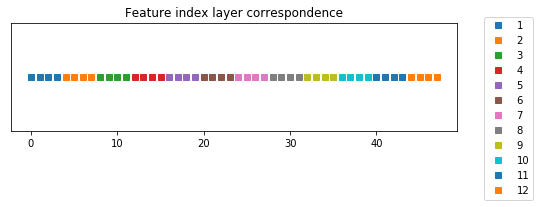

In [27]:
plt.figure(figsize=(8, 2))
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='s', linestyle='None', label=k+1)
_=plt.title('Feature index layer correspondence')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.1))

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

In [28]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
ns = 8

models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)
print ('candidate count = ', len(models))

sample_batch_size = 200
voxel_batch_size = 500
holdout_size = 3000
lambdas = np.logspace(3.,7.,9, dtype=np.float32)

candidate count =  875


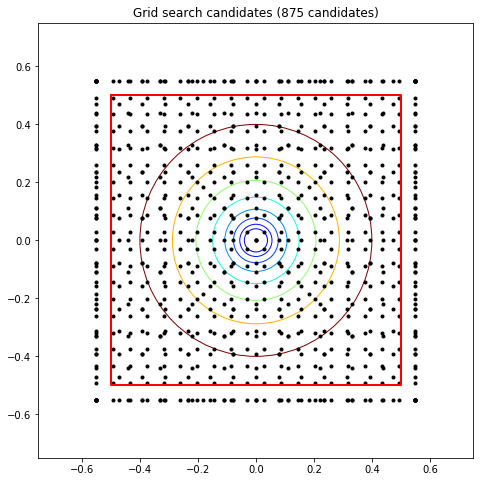

In [29]:
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

lx, vx = aperture, aperture * 1.5
cNorm  = colors.Normalize(vmin=.0, vmax=.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') )

plt.figure(figsize=(8, 8))
plt.title('Grid search candidates (%d candidates)' % len(models))
plt.plot(models[:,0], models[:,1], '.k', linestyle='None')
ax = plt.gca()
for s in np.unique(models[:,2]):
    ax.add_artist(Ellipse(xy=(0,0), width=2*s, height=2*s, angle=0,
        color=scalarMap.to_rgba(s), lw=1, fill=False))
_=ax.set_xlim(-vx/2, vx/2)
_=ax.set_ylim(-vx/2, vx/2)
_=ax.set_aspect('equal')
plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r', lw=2)

In [30]:
from src.torch_fwrf import  learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block

best_losses, best_lambdas, best_params = learn_params_ridge_regression(
    trn_stim_data, trn_voxel_data, _fmaps_fn, models, lambdas, \
    aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)

trn_size = 24000 (88.9%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([200, 4, 381, 381])
torch.Size([200, 4, 297, 297])
torch.Size([200, 4, 232, 232])
torch.Size([200, 4, 181, 181])
torch.Size([200, 4, 142, 142])
torch.Size([200, 4, 111, 111])
torch.Size([200, 4, 87, 87])
torch.Size([200, 4, 68, 68])
torch.Size([200, 4, 53, 53])
torch.Size([200, 4, 42, 42])
torch.Size([200, 4, 33, 33])
torch.Size([200, 4, 26, 26])
---------------------------------------

model  874 of 875 , voxels [238500:238507] of 238508
---------------------------------------
total time = 70556.744192s
total throughput = 0.295825s/voxel
voxel throughput = 0.195528s/voxel
setup throughput = 27.339281s/model


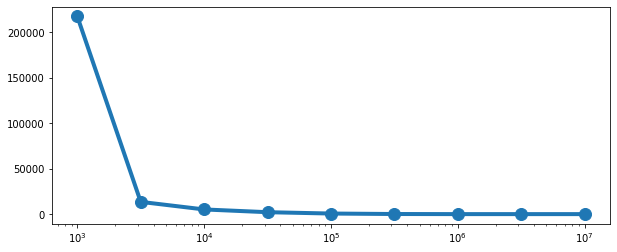

In [31]:
plt.figure(figsize=(10,4))
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')

In [32]:
print ([p.shape if p is not None else None for p in best_params])

[(238508, 3), (238508, 48), (238508,), (238508, 48), (238508, 48)]


In [33]:
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]

_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=image_data.shape, aperture=1.0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [34]:
voxel_pred = get_predictions(val_image_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

samples [    0:199  ] of 1000, voxels [     0:499   ] of 238508

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


samples [  800:999  ] of 1000, voxels [238500:238507] of 238508
---------------------------------------
total time = 2712.997328s
sample throughput = 2.712997s/sample
voxel throughput = 0.011375s/voxel


In [35]:
val_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

 51%|█████     | 120926/238508 [00:18<00:18, 6418.86it/s]/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
100%|██████████| 238508/238508 [00:37<00:00, 6406.34it/s]


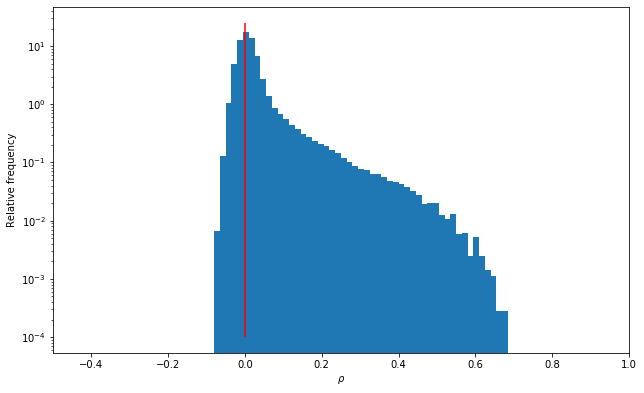

In [36]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.5, 1.0])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

In [37]:
best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

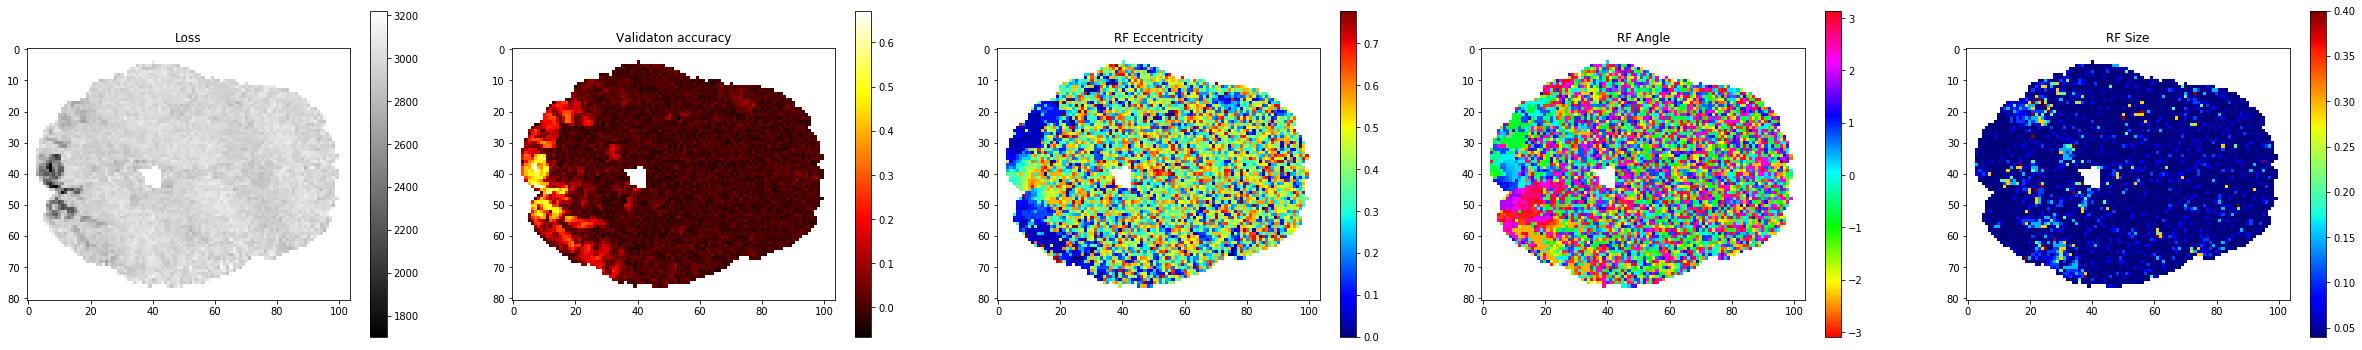

In [38]:
volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")

slice_idx = 40
fig = plt.figure(figsize=(42,6))
plt.subplot(1,5,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(1,5,2)
plt.title('Validaton accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(1,5,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(1,5,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(1,5,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

# Save results to disk

In [39]:
model_params = {
    'lmask': lmask,
    'fmask': fmask,
    'tuning_masks': tuning_masks,
    'aperture': aperture,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'val_size': val_size,
    'trn_size': trn_size,
    'shared_mask': shared_mask,
    'image_order': ordering_data,
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi,
    'params': best_params,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'val_cc': val_cc,
    }

print (timestamp)
save_stuff(output_dir + "model_params", flatten_dict(model_params))

May-24-2020_1943
saved lmask@0 in h5py file
saved lmask@1 in h5py file
saved lmask@2 in h5py file
saved lmask@3 in h5py file
saved lmask@4 in h5py file
saved lmask@5 in h5py file
saved lmask@6 in h5py file
saved lmask@7 in h5py file
saved lmask@8 in h5py file
saved lmask@9 in h5py file
saved lmask@10 in h5py file
saved lmask@11 in h5py file
saved fmask@0 in h5py file
saved fmask@1 in h5py file
saved fmask@2 in h5py file
saved fmask@3 in h5py file
saved fmask@4 in h5py file
saved fmask@5 in h5py file
saved fmask@6 in h5py file
saved fmask@7 in h5py file
saved fmask@8 in h5py file
saved fmask@9 in h5py file
saved fmask@10 in h5py file
saved fmask@11 in h5py file
saved tuning_masks@0 in h5py file
saved tuning_masks@1 in h5py file
saved tuning_masks@2 in h5py file
saved tuning_masks@3 in h5py file
saved tuning_masks@4 in h5py file
saved tuning_masks@5 in h5py file
saved tuning_masks@6 in h5py file
saved tuning_masks@7 in h5py file
saved tuning_masks@8 in h5py file
saved tuning_masks@9 in h

---

# Compare validation accuracy value to previous method

In [38]:
pre_cc_volume  = load_mask_from_nii(root_dir+"output/S%02d/%s_%s/val_cc.nii" % (subject, 'dnn_fwrf', 'Mar-27-2020_0301'))
pre_cc = pre_cc_volume.flatten()[voxel_mask]

<Figure size 576x576 with 0 Axes>

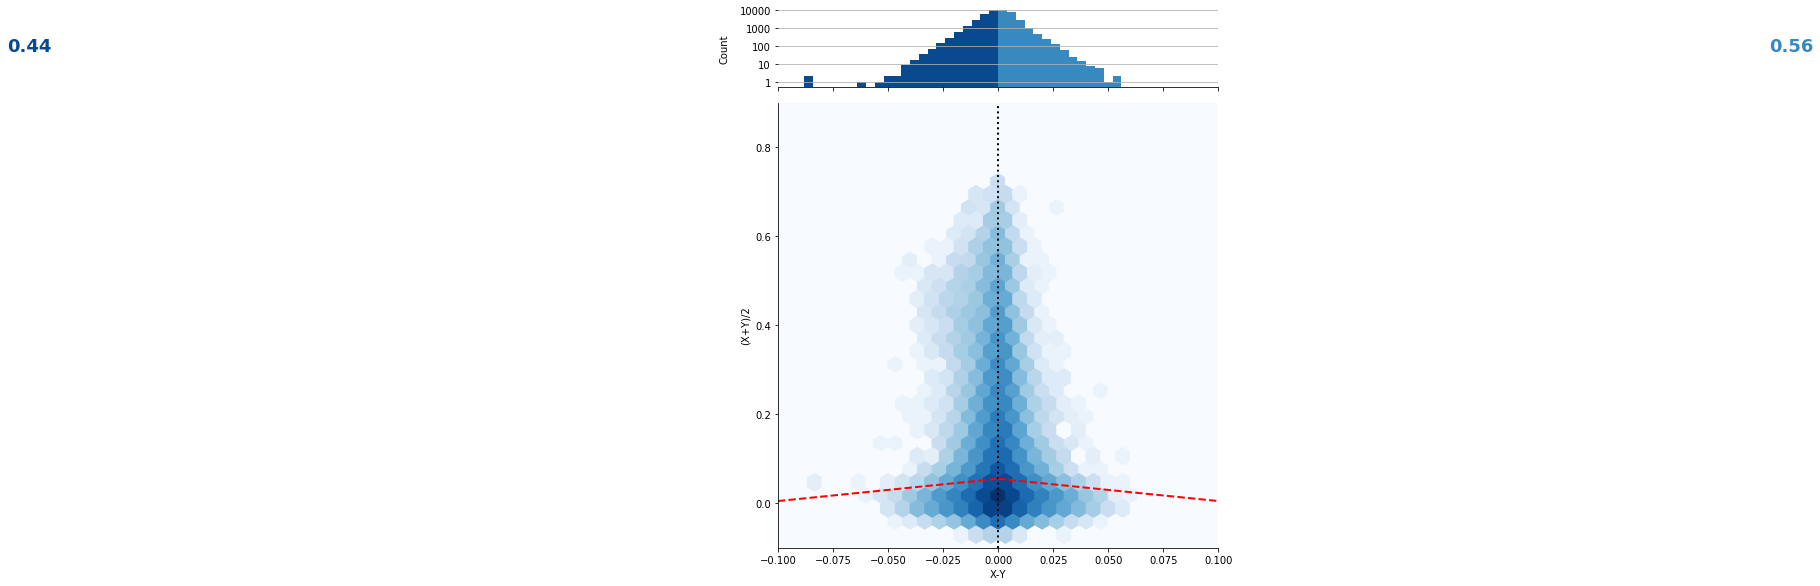

In [40]:
from src.plots import plot_fwrf_paper_compare

fig=plt.figure(figsize=(8, 8))
_=plot_fwrf_paper_compare(pre_cc, val_cc, 0.055, [-.1, .1], [-.1, .9])

# Training sample scaling

In [26]:
trn_sizes = np.array([1,2,3,6,9,18,27]) * 1000
holdout_perc = .2
ho_sizes = np.floor(holdout_perc * trn_sizes).astype(int)
print (trn_sizes)

[ 1000  2000  3000  6000  9000 18000 27000]


In [31]:
characteristics = {'trn_sizes': trn_sizes,
                  'ho_sizes': ho_sizes,
                  'voxel_index': voxel_idx,
                  'voxel_roi': voxel_roi,
                  'lambdas': lambdas}
###
for k,(ts,hs) in enumerate(zip(trn_sizes, ho_sizes)):  
    # training    
    best_losses, best_lambdas, best_params = learn_params_ridge_regression(
        trn_stim_data, trn_voxel_data, _fmaps_fn, models, lambdas, \
        aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
        voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)
    # validation    
    param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
    _fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_space=227, aperture=1.0)
    val_voxel_pred = get_predictions(val_stim_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)    
    # prediction accuracy
    val_cc = np.zeros(shape=(nv,), dtype=fpX)    
    for v in tqdm(range(nv)):    
        val_cc[v] = np.corrcoef(val_voxel_pred[:,v], val_voxel_data[:,v])[0,1]
    # null threshold  
    null_val_cc = np.zeros(shape=(10, nv), dtype=fpX)
    for i in range(10):
        shuff = np.arange(len(val_voxel_pred))
        np.random.shuffle(shuff)
        shuffled_val_pred = val_voxel_pred[shuff]
        for v in tqdm(range(nv)):    
            null_val_cc[i,v] = np.corrcoef(shuffled_val_pred[:,v], val_voxel_data[:,v])[0,1]
    cc_mn = np.mean(null_val_cc.flatten())
    cc_th = 3* np.std(null_val_cc.flatten())
    # save results 
    characteristics['result%d'%k] = {'trn_size': ts,
                          'best_lambdas': best_lambdas,
                          'cc_mn':        cc_mn,
                          'cc_th':        cc_th,
                          'val_cc':       val_cc}
    # print a summary
    print ('================================================')
    print ('median cc = %.3f, max cc = %.3f' % (np.median(val_cc), np.max(val_cc)))
    print ('================================================')
#################################################################    
characteristics['max_trn_size'] = trn_size
characteristics['val_size'] = val_size
## cc_threshold patch
cc_mns, cc_ths = [],[]
for i,ts in enumerate(characteristics['trn_sizes']):
    cc_mns += [characteristics['result%d'%i]['cc_mn'],]
    cc_ths += [characteristics['result%d'%i]['cc_th'],]  
cc_mn = np.mean(cc_mns)    
cc_th = np.mean(cc_ths)
print ("cc th = (%.3f, %.3f)" % (cc_mn, cc_th))
characteristics['cc_mn'] = cc_mn
characteristics['cc_th'] = cc_th

trn_size = 800 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 669.819758s
total throughput = 0.042773s/voxel
voxel throughput = 0.015491s/voxel
setup throughput = 0.588469s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 552/15660 [00:00<00:02, 5518.87it/s]


---------------------------------------
total time = 673.291628s
sample throughput = 0.224431s/sample
voxel throughput = 0.042994s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 6940.57it/s]


median cc = 0.155, max cc = 0.697
trn_size = 1600 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 983.663992s
total throughput = 0.062814s/voxel
voxel throughput = 0.020027s/voxel
setup throughput = 0.922931s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 565/15660 [00:00<00:02, 5642.16it/s]


---------------------------------------
total time = 645.753095s
sample throughput = 0.215251s/sample
voxel throughput = 0.041236s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 6897.07it/s]


median cc = 0.185, max cc = 0.707
trn_size = 2400 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 1228.225548s
total throughput = 0.078431s/voxel
voxel throughput = 0.024156s/voxel
setup throughput = 1.170729s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  3%|▎         | 537/15660 [00:00<00:02, 5363.80it/s]


---------------------------------------
total time = 636.530227s
sample throughput = 0.212177s/sample
voxel throughput = 0.040647s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7059.75it/s]


median cc = 0.199, max cc = 0.710
trn_size = 4800 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 2334.165585s
total throughput = 0.149053s/voxel
voxel throughput = 0.042394s/voxel
setup throughput = 2.300664s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 560/15660 [00:00<00:02, 5592.67it/s]


---------------------------------------
total time = 615.397670s
sample throughput = 0.205133s/sample
voxel throughput = 0.039297s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7022.46it/s]


median cc = 0.215, max cc = 0.721
trn_size = 7200 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 3233.486409s
total throughput = 0.206481s/voxel
voxel throughput = 0.057213s/voxel
setup throughput = 3.219746s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 565/15660 [00:00<00:02, 5640.67it/s]


---------------------------------------
total time = 530.243497s
sample throughput = 0.176748s/sample
voxel throughput = 0.033860s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7195.65it/s]


median cc = 0.223, max cc = 0.724
trn_size = 14400 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 5283.283254s
total throughput = 0.337374s/voxel
voxel throughput = 0.100990s/voxel
setup throughput = 5.098865s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 565/15660 [00:00<00:02, 5649.92it/s]


---------------------------------------
total time = 485.605738s
sample throughput = 0.161869s/sample
voxel throughput = 0.031009s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7060.83it/s]


median cc = 0.233, max cc = 0.732
trn_size = 21600 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 8835.875487s
total throughput = 0.564232s/voxel
voxel throughput = 0.215589s/voxel
setup throughput = 7.520317s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 571/15660 [00:00<00:02, 5702.15it/s]


---------------------------------------
total time = 458.248451s
sample throughput = 0.152749s/sample
voxel throughput = 0.029262s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7208.22it/s]

median cc = 0.237, max cc = 0.736
cc th = (-0.000, 0.055)


## Save scaling data

In [32]:
param_file_name = "dnn_fwrf_%s_scaling" % (timestamp)
print (param_file_name)

save_stuff(output_dir + param_file_name, flatten_dict(characteristics))

dnn_fwrf_Apr-06-2020_2050_scaling
saved trn_sizes in h5py file
saved ho_sizes in h5py file
saved voxel_index in h5py file
saved voxel_roi in h5py file
saved lambdas in h5py file
saved result0.trn_size in h5py file
saved result0.best_lambdas in h5py file
saved result0.cc_mn in h5py file
saved result0.cc_th in h5py file
saved result0.val_cc in h5py file
saved result1.trn_size in h5py file
saved result1.best_lambdas in h5py file
saved result1.cc_mn in h5py file
saved result1.cc_th in h5py file
saved result1.val_cc in h5py file
saved result2.trn_size in h5py file
saved result2.best_lambdas in h5py file
saved result2.cc_mn in h5py file
saved result2.cc_th in h5py file
saved result2.val_cc in h5py file
saved result3.trn_size in h5py file
saved result3.best_lambdas in h5py file
saved result3.cc_mn in h5py file
saved result3.cc_th in h5py file
saved result3.val_cc in h5py file
saved result4.trn_size in h5py file
saved result4.best_lambdas in h5py file
saved result4.cc_mn in h5py file
saved res

## Figures

Text(0, 0.5, 'Count')

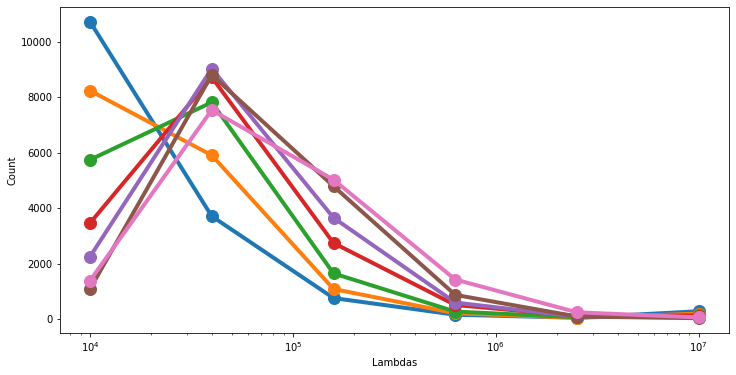

In [34]:
fig=plt.figure(figsize=(12,6))
for i,ts in enumerate(trn_sizes):
    plt.plot(lambdas, [np.sum(characteristics['result%d'%i]['best_lambdas']==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.xlabel('Lambdas')
plt.ylabel('Count')

In [35]:
result_cc, cc_ths, cc_mns, median_cc, top_cc, count_cc = [],[],[],[],[],[]
for i,ts in enumerate(trn_sizes):
    cc_mns += [characteristics['result%d'%i]['cc_mn'],]
    cc_ths += [characteristics['result%d'%i]['cc_th'],]
    result_cc += [characteristics['result%d'%i]['val_cc'],]
    median_cc += [np.median(characteristics['result%d'%i]['val_cc'])]
    top_cc += [np.max(characteristics['result%d'%i]['val_cc'])]
cc_mn = np.mean(cc_mns)    
cc_th = np.mean(cc_ths)
for i,ts in enumerate(trn_sizes):
    count_cc += [np.sum(characteristics['result%d'%i]['val_cc']>(cc_mn+cc_th))]

Text(0, 0.5, 'Above threshold')

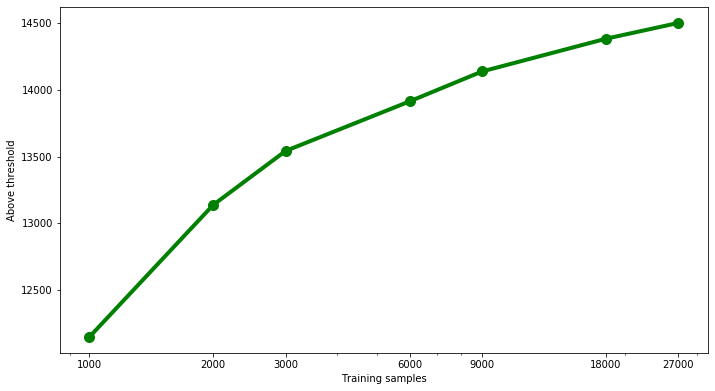

In [50]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
plt.plot([min(trn_size,s) for s in trn_sizes], count_cc, marker='o', ms=10, color='g', lw=4)
plt.xscale('log')
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Above threshold')

In [52]:
filename = output_dir + "validation_above_threshold_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

Text(0, 0.5, 'Validation accuracies')

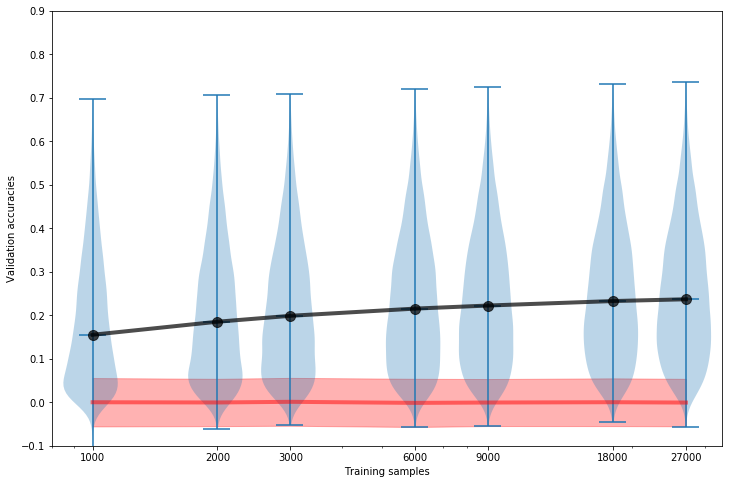

In [53]:
fig=plt.figure(figsize=(12,8))
#plt.hlines(y=[0], xmin=800, xmax=33000, color='r', lw=4, alpha=.5)
plt.plot([min(trn_size,s) for s in trn_sizes], cc_mns, color='r', lw=4, alpha=.5)
plt.fill_between([min(trn_size,s) for s in trn_sizes], np.array(cc_mns)-np.array(cc_ths), np.array(cc_mns)+np.array(cc_ths), color='r', alpha=0.3)
plt.violinplot(result_cc, positions=[min(trn_size,s) for s in trn_sizes], widths=np.array([min(trn_size,s) for s in trn_sizes])*.3, showmedians=True)
plt.plot([min(trn_size,s) for s in trn_sizes], median_cc, marker='o', ms=10, color='k', lw=4, alpha=.7)
plt.xscale('log')
plt.xlim([800, 33000])
plt.ylim([-.1, .9])
plt.gca().set_yticks(np.linspace(-.1,.9, 11))
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Validation accuracies')

# Run patch on previous file format

In [87]:
#output_dir = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/'
#filenames = [
#    'S01/dnn_fwrf_Mar-27-2020_0301_params',
#    'S02/dnn_fwrf_Apr-01-2020_0250_params',
#    'S05/dnn_fwrf_Mar-29-2020_2349_params',
#    'S06/dnn_fwrf_Mar-31-2020_0220_params'
#]

In [99]:
#for filename in filenames[1:]:
#    model_params_set = h5py.File(output_dir + '%s.h5py' % filename, 'r')
#    model_params = embed_dict({k: np.copy(d) for k,d in model_params_set.items()})
#    print (model_params.keys())
#    model_params_set.close()
#    
#    model_params['params'] = [model_params['rf_params'],] + model_params['w_params'] + [model_params['normavg'], model_params['normstd']]
#    
#    model_params.pop('rf_params')
#    model_params.pop('w_params')
#    model_params.pop('normavg')
#    model_params.pop('normstd')
#    
#    print (model_params.keys())
#    
#    save_stuff(output_dir + '%s' % filename, flatten_dict(model_params))

dict_keys(['aperture', 'best_lambdas', 'brain_nii_shape', 'fmask', 'image_order', 'lambdas', 'lmask', 'normavg', 'normstd', 'rf_params', 'shared_mask', 'trn_size', 'tuning_masks', 'val_cc', 'val_size', 'voxel_index', 'voxel_mask', 'voxel_roi', 'w_params'])
dict_keys(['aperture', 'best_lambdas', 'brain_nii_shape', 'fmask', 'image_order', 'lambdas', 'lmask', 'shared_mask', 'trn_size', 'tuning_masks', 'val_cc', 'val_size', 'voxel_index', 'voxel_mask', 'voxel_roi', 'params'])
saved aperture in h5py file
saved best_lambdas in h5py file
saved brain_nii_shape in h5py file
saved fmask@0 in h5py file
saved fmask@1 in h5py file
saved fmask@2 in h5py file
saved image_order in h5py file
saved lambdas in h5py file
saved lmask@0 in h5py file
saved lmask@1 in h5py file
saved lmask@2 in h5py file
saved shared_mask in h5py file
saved trn_size in h5py file
saved tuning_masks@0 in h5py file
saved tuning_masks@1 in h5py file
saved tuning_masks@2 in h5py file
saved tuning_masks@3 in h5py file
saved tuning_

In [1]:
import sys
import os
import struct
import time as time
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
def f(delta, alpha, beta):
    db = np.power(np.abs(delta), beta)
    return db /(db + np.power(alpha, beta))

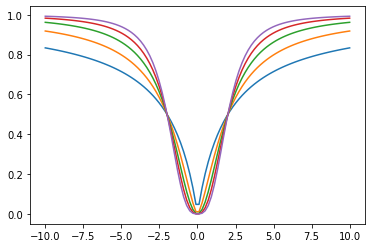

In [17]:
delta = np.linspace(-10, 10, 100)
for beta in [1., 1.5, 2., 2.5, 3]:
    plt.plot(delta, f(delta, 2., beta))